# Recommendation Engine with Online Judge Platforms


Recommending the questions that a programmer should solve given his/her current expertise is a big challenge for Online Judge Platforms but is an essential task to keep a programmer engaged on their platform.

In this practice problem, I have used the data of programmers and questions that they have previously solved along with the time that they took to solve that particular question.

As a data scientist, my task was to build a model that can predict the time taken to solve a problem given the user current status.

## Problem Statement

Online judges provide a platform where many users solve problems everyday to improve their programming skills. The users can be beginners or experts in competitive programming. Some users might be good at solving specific category of problems(e.g. Greedy, Graph algorithms, Dynamic Programming etc.) while others may be beginners in the same. There can be patterns to everything, and the goal of the machine learning would be to identify these patterns and model user’s behaviour from these patterns.

The goal of this challenge is to predict range of attempts a user will make to solve a given problem given user and problem details. Finding these patterns can help the programming committee, as it will help them to suggest relevant problems to solve and provide hints automatically on which users can get stuck.

## Data

Is a collected user submissions for various problems from an online judge platform. The submissions data consists of 2,21,850 submissions of 3,571 users and 6,544 problems.

There are 3 training data files:

* 1- train_submissions.csv - This contains 1,55,295 submissions which are selected randomly from 2,21,850 submissions.
* 2- user_data.csv - This is the file containing data of users.
* 3- problem_data.csv - This is the file containing data of the problems.

There are 2 testing data files:

* 1- test_submissions.csv - This contains the remaining 66,555 submissions from total 2,21,850 submissions.
* 2- sample_submissions.csv - This contains the predictions of the model on the test_submissions.csv file.

### Metrics

The metrics used for evaluating the performance of the model is the F1 score between the predicted and the actual value with average parameter set to ‘weighted’ .



### About Online Judge Platforms

The [SPOJ platform](https://www.spoj.com/) is centered around an online judge system, which serves for the automatic assessment of user-submitted programs. Some of its most important features include:

* support for more than 45 programming languages and compilers, including C, C++, Pascal, JAVA, C#, Perl, Python, Ruby, Haskell, Ocaml, and esoteric languages.
* a rapidly growing problem-set of about 13000 tasks available for practice 24hours/day (in English, Polish, Vietnamese, Portuguese and other languages), including many original tasks prepared by the community of expert problemsetters associated with the project.
* a flexible testing system, supporting dynamic interaction with submitted programs and highly customisable output of assessment results.
* intuitive browser-based content management which allows users to set up their own contests within a matter of minutes, and to make use of tasks already available in the system.
* more than 2400 contests hosted as of 2012, ranging from instant challenges to long-term e-learning courses.

### Credit

Must give credit to Analytics Vidhya for build this challange, and to Udacity courses for helping me to understanting this powerfull techniques to solve such is challanges.

[Analytics Vidhya contest URL](https://datahack.analyticsvidhya.com/contest/practice-problem-recommendation-engine/)

[Udacity program URL](https://mena.udacity.com/course/data-scientist-nanodegree--nd025)

In [1]:
# import all liparise

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import defaultdict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

In [2]:
problem = pd.read_csv('problem_data.csv')
submissions = pd.read_csv('train_submissions.csv')
user = pd.read_csv('user_data.csv')
test_submissions = pd.read_csv('test_submissions_NeDLEvX.csv')
sample_submissions = pd.read_csv('sample_submissions_wbscxqU.csv')

## Data Exploration

We are going to understanding the data before we are starting with submissions datasets.

### train / test submissions.csv

In [177]:
submissions.head()

,user_id,problem_id,attempts_range
0,user_232,prob_6507,1
1,user_3568,prob_2994,3
2,user_1600,prob_5071,1
3,user_2256,prob_703,1
4,user_2321,prob_356,1


Contains 3 columns: 

* 1- ‘user_id’ the ID that assigned to each user.
* 2- ‘problem_id’ the ID that assigned to each problem.
* 3 - ‘attempts_range’ denoted the range no. in which attempts the user made to get the solution accepted lies.

Define the attempts_range :-

            attempts_range            No. of attempts lies inside
            1                                         1-1
            2                                         2-3
            3                                         4-5
            4                                         6-7
            5                                         8-9
            6                                         >=10

In [573]:
print('Number of nans is:\n',  submissions.isnull().sum(), '\n Number of record is:', submissions.shape[0])

Number of nans is:
 user_id           0
problem_id        0
attempts_range    0
dtype: int64 
 Number of record is: 155295


In [592]:
test_submissions.head()

,ID,user_id,problem_id
0,user_856_prob_5822,user_856,prob_5822
1,user_2642_prob_2334,user_2642,prob_2334
2,user_2557_prob_2920,user_2557,prob_2920
3,user_1572_prob_4598,user_1572,prob_4598
4,user_295_prob_6139,user_295,prob_6139


Test submissions contains column (ID) "where ID is the concatenation of user_id and problem_id", user_id, and problem_id. The ‘attempts_range’ column is to be predicted

In [593]:
print('Number of nans is:\n',  test_submissions.isnull().sum(), '\n Number of record is:', test_submissions.shape[0])

Number of nans is:
 ID            0
user_id       0
problem_id    0
dtype: int64 
 Number of record is: 66555


We can see in submissions datasets there no null data and we can use the to create user matrix with the provlem based on attempt range, also we can see test submissions also is look ready to use but we need to check if all users and problems exist in the submissions list, and now lets see problem dataset.

### problem.csv

In [552]:
problem.head()

,problem_id,level_type,points,tags
0,prob_3649,H,NaN,NaN
1,prob_6191,A,NaN,NaN
2,prob_2020,F,NaN,NaN
3,prob_313,A,500.0,"greedy,implementation"
4,prob_101,A,500.0,"constructive algorithms,greedy,math"


Contains 4 columns
* 1- problem_id - unique ID assigned to each problem
* 2- level_id - the difficulty level of the problem between ‘A’ to ‘N’ "categorical"
* 3- points - amount of points for the problem "numerical"
* 4- tags - problem tag(s) like greedy, graphs, DFS etc. "text analysis"

In [575]:
print('Number of nans is:\n',  problem.isnull().sum(), '\n Number of record is:', problem.shape[0])

Number of nans is:
 problem_id       0
level_type     133
points        3917
tags          3484
dtype: int64 
 Number of record is: 6544


We can see here may nan's in points and tags 

### user.csv

In [576]:
user.head()

,user_id,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds
0,user_3311,47,40,0,NaN,4,1504111645,348.337,330.849,intermediate,1466686436
1,user_3028,63,52,0,India,17,1498998165,405.677,339.450,intermediate,1441893325
2,user_2268,226,203,-8,Egypt,24,1505566052,307.339,284.404,beginner,1454267603
3,user_480,611,490,1,Ukraine,94,1505257499,525.803,471.330,advanced,1350720417
4,user_650,504,479,12,Russia,4,1496613433,548.739,486.525,advanced,1395560498


It contains the following features :-
* user_id - unique ID assigned to each user
* submission_count - total number of user submissions
* problem_solved - total number of accepted user submissions
* contribution - user contribution to the judge
* country - location of user
* follower_count - amount of users who have this user in followers
* last_online_time_seconds - time when user was last seen online
* max_rating - maximum rating of user
* rating - rating of user
* rank - can be one of ‘beginner’ ,’intermediate’ , ‘advanced’, ‘expert’
* registration_time_seconds - time when user was registered

In [577]:
print('Number of nans is:\n',  user.isnull().sum(), '\n Number of record is:', user.shape[0])

Number of nans is:
 user_id                         0
submission_count                0
problem_solved                  0
contribution                    0
country                      1153
follower_count                  0
last_online_time_seconds        0
max_rating                      0
rating                          0
rank                            0
registration_time_seconds       0
dtype: int64 
 Number of record is: 3571


Is look like there missing values in country feature only.

## Data Visualization & Analysis

### Submissions Analysis

In [176]:
print('Number of problems in test data are =', test_submissions.problem_id.unique().shape[0])
print('Number of problems in train data are =', submissions.problem_id.unique().shape[0])

print('Number of users in test data are =', test_submissions.user_id.unique().shape[0])
print('Number of users in train data are =', submissions.user_id.unique().shape[0])

print('Users who are in test data but they are not in training data is = ', np.setdiff1d(test_submissions.user_id.unique(), submissions.user_id.unique()).shape[0])
print('Problems who are in test data but they are not in training data is = ', np.setdiff1d(test_submissions.problem_id.unique(), submissions.problem_id.unique()).shape[0])

Number of problems in test data are = 4716
Number of problems in train data are = 5776
Number of users in test data are = 3501
Number of users in train data are = 3529
Users who are in test data but they are not in training data is =  12
Problems who are in test data but they are not in training data is =  436


**OK, is look like there a 12 users we don't have any information about how they interacted with problems also we have a 436 problems without any interact.**

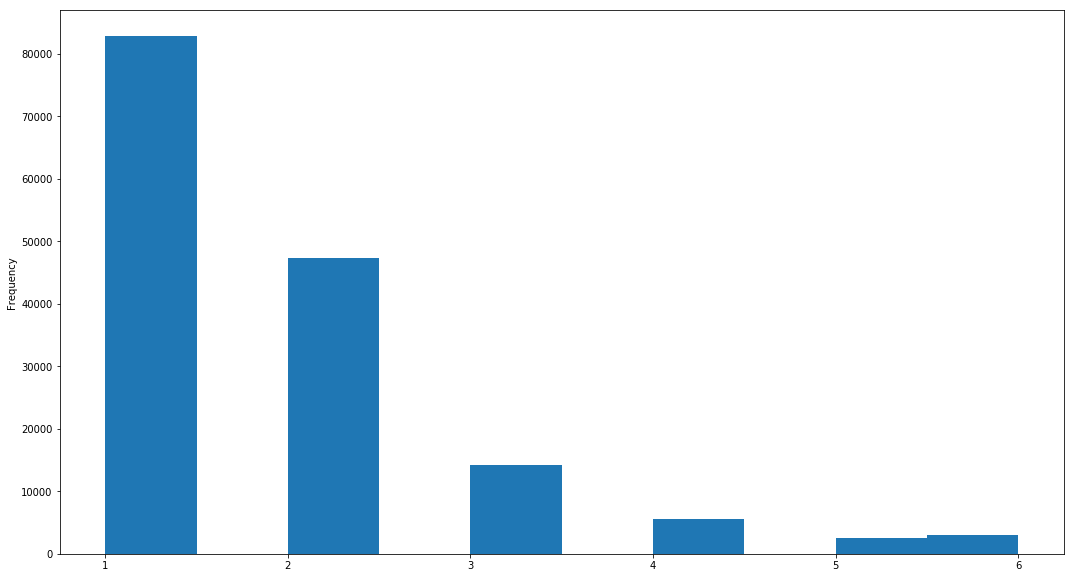

In [11]:
submissions.attempts_range.plot(kind = 'hist', figsize = (18,10));

** 80K problems are solved by 1 attempt, and it is reduced by half in other ranges **

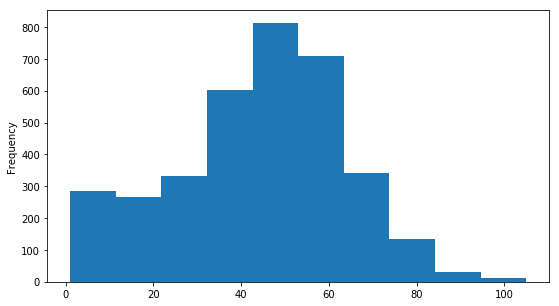

In [594]:
submissions.user_id.value_counts().plot(kind = 'hist', figsize = (9,5));

** Only few users who have solved more than 60 problems in our submissions dataset and most of them are solve between 20 and 60 **

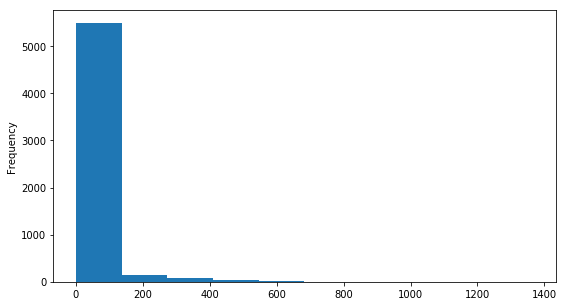

In [3]:
submissions.problem_id.value_counts().plot(kind = 'hist', figsize = (9,5));

** We can see here there some famous problems that have more than 100 solver untill to 1400, but most of them are between 1 to 150 **

### Problem Analysis

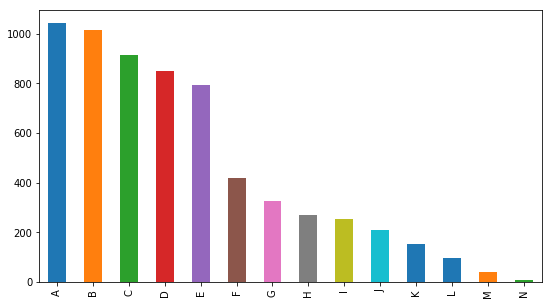

In [4]:
problem.level_type.value_counts().plot(kind = 'bar', figsize = (9,5));

** We can see here most of the problem from level type A and only very few problems from type M and N**

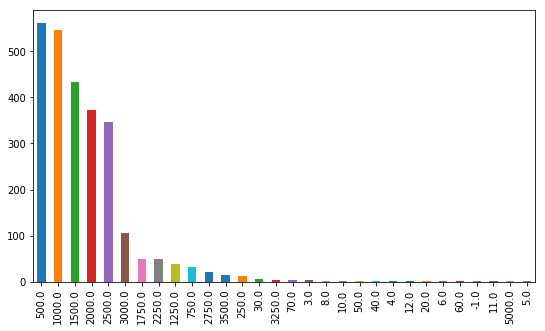

In [8]:
problem.points.value_counts().plot(kind = 'bar', figsize = (9,5));

** And regarding the points the 500&100 they are the most values in problem dataset, also there value like -1 is look as outlier **

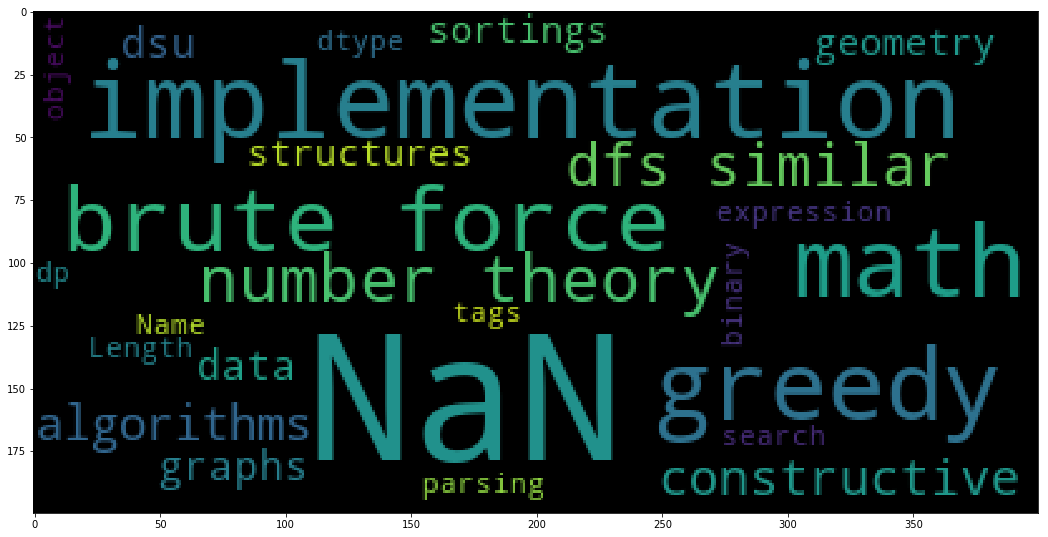

In [240]:
wordcloud = WordCloud().generate(str(problem.tags))   
plt.figure(figsize=(18, 10))
plt.imshow(wordcloud)
plt.show()

** As we have seen that there many Nan's in problem dataset for the feature tags, we can see that apear here also is showing the tag implementation is the frist word frequency in our dataset **

### User Analysis

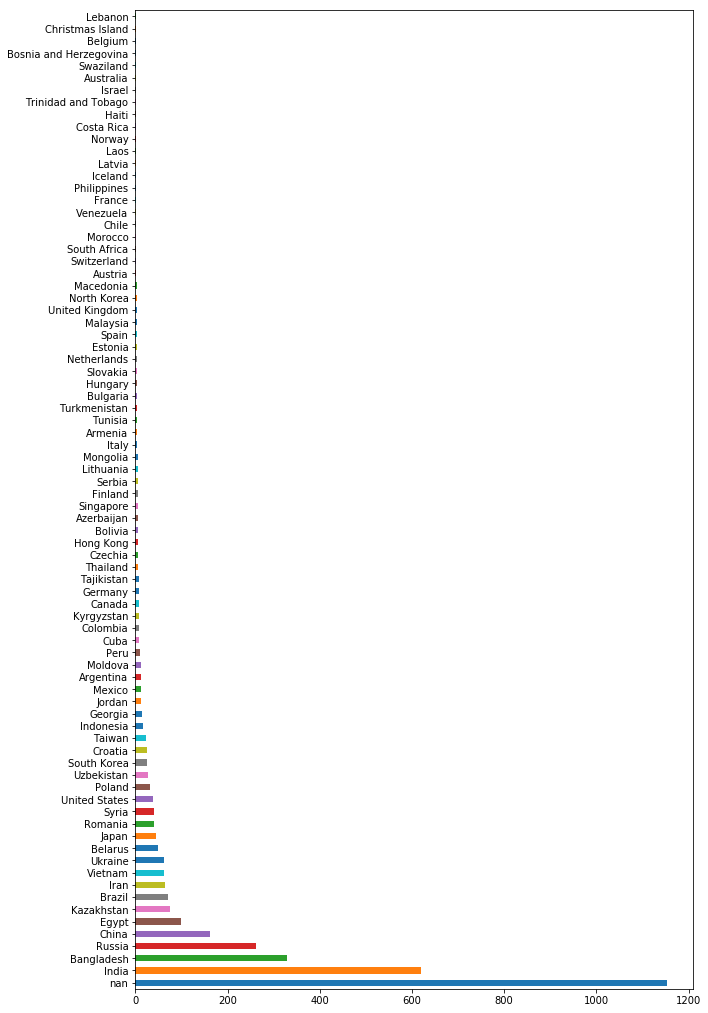

In [99]:
user.country.value_counts(dropna=False).plot(kind = 'barh', figsize = (10,18));

** For the feature country in Users dataset we can see that Nan's have the hights value since there a lot of missing values and the second is India **

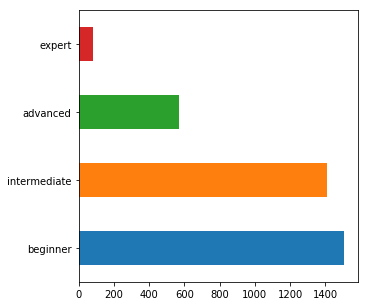

In [9]:
user['rank'].value_counts().plot(kind = 'barh', figsize = (5,5));

** For the feature Rank in Users dataset we can see in our dataset the most of the users are beginner **

## Data Preprocessing

Now we have understand the data and since we have many of features need to some processing to help us to solve our problem to predict how many attempts for the users by finding patterns between current data of submissions, users, and problem.

Preprocessing include make the categorical data to dummies, normalize the data, and fix missing values.

In [143]:
def dummies (data_frame, data_col, weight = 1):
    
    '''
    This function change the type of categorical data to numrical type and remove old the categorical colmn
    
    INPUT:
    data_frame - pd.DataFrame: have the columns that we want to make it dummy
    data_col - string: for the column we ant to make it a dummy

    
    OUTPUT:
    data_frame - pd.DataFrame: data frame have changed the column to dummy also old column removed
    
    '''
    
    dummy = pd.get_dummies(data_frame[data_col])
    data_frame.drop(columns = data_col, inplace = True)
    data_frame = data_frame.join(dummy * weight)
    
    return data_frame

In [144]:
def normalization (data_ser, data_frame, data_col, weight = 1):
        
    '''
    This function normalize numrical data 
    
    INPUT:
    data_frame - pd.DataFrame: have the column that we want to make it normlized
    data_ser - pd.Series: the column that we want to normlized
    data_col - string: for the column we ant to make it a normlized

    
    OUTPUT:
    data_frame - pd.DataFrame: data frame have normlized the column
    
    '''
    
    normal_points = data_ser.values.astype(float)
    minmaxscaler = preprocessing.MinMaxScaler()
    normalized = pd.DataFrame(minmaxscaler.fit_transform(normal_points), columns = [data_col])
    data_frame = data_frame.drop(columns = data_col)
    data_frame = data_frame.join(normalized * weight)

    return data_frame

In [503]:
def predict_missing(df, na_cols, cols):
            
    '''
    This function will create a model that can find patrens in dataset then will predict on the missing values of it 
    
    INPUT:
    df - pd.DataFrame: have the columns that we want to predict the missing value for them
    na_cols - list: list of columns that have missing values
    cols - list: the columns that without any missing values

    
    OUTPUT:
    df_pred - pd.DataFrame: that contains the rows that have missing values now are filled in.
    y_pred_ids - list: list of rows that we have fixed them
    
    '''
    
    y_tri_ids = df[na_cols].notnull().all(axis=1)
    y_pred_ids = df[na_cols].isnull().all(axis=1)
    df_trin = df[y_tri_ids]
    df_pred = df[y_pred_ids]

    model = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.01,
                                                                  n_estimators=1000,
                                                                  subsample=.80,))
    model.fit(df_trin[cols], df_trin[na_cols])
    
    df_pred[na_cols] = model.predict(df_pred[cols])

    
    return df_pred, y_pred_ids

#### Create problem matrix

Now we will create matrix for all the prolbems and we are tring to capture most of other information from submission dataset and from user data set.

In [519]:
# Let's merge sumissions with user data

mat_prop = pd.merge(submissions, user, on = 'user_id')

# Let's normlize nurmical data

norms_cols = ['submission_count', 'problem_solved', 'contribution',
       'follower_count', 'max_rating', 'rating', 
            'last_online_time_seconds', 'registration_time_seconds',
              'attempts_range']

for col in norms_cols:
    mat_prop = normalization(mat_prop[[col]], mat_prop, col)

    
# Let's fix categorical data

mat_prop = dummies(mat_prop, 'rank')

# Let's drop the columns that we don't need from users data set

mat_prop.drop(columns = 'user_id', inplace = True)
mat_prop.drop(columns = 'country', inplace = True)

C:\Users\Khaled\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Khaled\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,submission_count,problem_solved,contribution,follower_count,max_rating,rating,last_online_time_seconds,registration_time_seconds,attempts_range,advanced,...,sortings,special,string,strings,structures,suffix,ternary,theorem,theory,trees
problem_id,,,,,,,,,,,,,,,,,,,,,
prob_1,0.112935,0.103128,0.270213,0.003026,0.237230,0.508024,0.974896,0.146546,0.100000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prob_10,0.036988,0.035084,0.340426,0.006336,0.273111,0.520453,0.996808,0.429963,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prob_100,0.074196,0.074190,0.272340,0.000567,0.301816,0.558528,0.969563,0.442543,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prob_1000,0.041035,0.035844,0.275419,0.001952,0.083454,0.339940,0.836010,0.773264,0.041463,0.085366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prob_1001,0.203524,0.192983,0.468936,0.024520,0.484846,0.644588,0.923671,0.288198,0.020000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Let's merge the old dataset with problem dataset by adding 
# all the problems also that are not in submission

mat_prop = pd.merge(problem_matrix, problem, how = 'outer', on = 'problem_id')

# Let's fix nan's in points and normlize it

mat_prop.points.fillna(0, inplace= True)
mat_prop = normalization(mat_prop[['points']], mat_prop, 'points')

# Make level type to dummy
mat_prop = dummies(mat_prop, 'level_type')

# Fix nan's in tags and vectorize it
mat_prop['tags'].fillna(" ", inplace=True)

count_vector = CountVectorizer(stop_words='english')
count_vector.fit(mat_prop['tags'])
doc_array = count_vector.transform(mat_prop['tags']).toarray()
frequency_matrix = pd.DataFrame(doc_array, columns = count_vector.get_feature_names())

# let's normalize the tags freqyency data frame
for col in frequency_matrix.columns:
    frequency_matrix = normalization(frequency_matrix[[col]], frequency_matrix, col)

# To join the tags freqyency matrix to our dataset
mat_prop = mat_prop.join(frequency_matrix)

In [ ]:
# Now let's group by problem id, frist let's defined the columns that we want to use them in this matrix

cols_list = list(mat_prop.columns)
cols_list.remove ('problem_id')

mat_prop = mat_prop.groupby(['problem_id'])[cols_list].mean()

# Now let's difined that columns that have nan's so we can predict thier values

cols_notnan = mat_prop.columns[mat_prop.notnull().all(axis=0) == True]
cols_nan = mat_prop.columns[mat_prop.notnull().all(axis=0) == False]

# Use predict_missing funcation to these columns and save the predicted result

df_pred, y_pred_ids = predict_missing(mat_prop, cols_nan, cols_notnan)
mat_prop[y_pred_ids] = df_pred

mat_prop.head()

#### Create user matrix

Now we will create matrix for all the user and we are tring to capture most of other information from submission dataset and from problem dataset.

In [505]:
# Let's merge submissions with problem data

users1_matrix = pd.merge(submissions, problem, on = 'problem_id')

# Let's fix nan's in points and normlize it with attempts

users1_matrix.points.fillna(0, inplace= True)
users1_matrix = normalization(users1_matrix[['points']], users1_matrix, 'points')
users1_matrix = dummies(users1_matrix, 'attempts_range')

# Make level type to dummy

users1_matrix = dummies(users1_matrix, 'level_type')

# Let's drop the columns that we don't need from users problem dataset

users1_matrix.drop(columns = 'tags', inplace = True)
users1_matrix.drop(columns = 'problem_id', inplace = True)

C:\Users\Khaled\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Khaled\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,points,A,B,C,D,E,F,G,H,I,...,Thailand,Trinidad and Tobago,Tunisia,Turkmenistan,Ukraine,United Kingdom,United States,Uzbekistan,Venezuela,Vietnam
user_id,,,,,,,,,,,,,,,,,,,,,
user_1,0.270979,0.250000,0.183333,0.183333,0.183333,0.183333,0.016667,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
user_10,0.134499,0.529412,0.274510,0.137255,0.039216,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
user_100,0.194898,0.403509,0.280702,0.228070,0.087719,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
user_1000,0.183800,0.363636,0.400000,0.163636,0.072727,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
user_1001,0.202746,0.275862,0.293103,0.172414,0.120690,0.086207,0.017241,0.017241,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

# Let's merge the old dataset with user dataset by adding 
# all the users also that are not in submission

users1_matrix = pd.merge(users1_matrix, user, how = 'outer', on = 'user_id')

# Let's normlize nurmical data

norms_cols = ['submission_count', 'problem_solved', 'contribution',
       'follower_count', 'max_rating', 'rating', 
            'last_online_time_seconds', 'registration_time_seconds']

for col in norms_cols:
    users1_matrix = normalization(users1_matrix[[col]], users1_matrix, col)

# Let's fix categorical data

dummi_cols = ['rank', 'country']

for col in dummi_cols:
    users1_matrix = dummies(users1_matrix, col)


# Now let's group by user id, frist let's defined the columns that we want to use them in this matrix

cols_list = list(users1_matrix.columns)
cols_list.remove ('user_id')

users1_matrix = users1_matrix.groupby(['user_id'])[cols_list].mean()

In [ ]:
# Now let's difined that columns that have nan's so we can predict thier values

cols_notnan = users1_matrix.columns[users1_matrix.notnull().all(axis=0) == True]
cols_nan = users1_matrix.columns[users1_matrix.notnull().all(axis=0) == False]

# Use predict_missing funcation to these columns and save the predicted result

df_pred, y_pred_ids = predict_missing(users1_matrix, cols_nan, cols_notnan)
users1_matrix[y_pred_ids] = df_pred

users1_matrix.head()

#### Create sub matrix to test parameters 

In this matrix we will subset the top 100 problems in submissions then we will choose the top 100 users in this subset, in order to gentate a data frame 100*100.

In [228]:
# Top 100 problem
high_top_pros_ids = submissions.problem_id.value_counts().index[:100]

# Top 100 users in this 100 problem
high_top_users_ids = submissions.user_id[submissions.problem_id.isin(high_top_pros_ids)].value_counts().index[:100]

# Create new sub of submissions
new_sub = submissions[submissions.problem_id.isin(high_top_pros_ids)][submissions.user_id.isin(high_top_users_ids)]

C:\Users\Khaled\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [251]:
# Create a sample from this new subset to use it as validation

validtion = new_sub.sample(700)
len(validtion.user_id.value_counts()), len(validtion.problem_id.value_counts())

(100, 100)

In [261]:
# Create a traning list

training = new_sub[~new_sub.index.isin(validtion.index)]
len(training.user_id.value_counts()), len(training.problem_id.value_counts())

(100, 100)

In [ ]:
parmeter_matrix = training.groupby(['user_id', 'problem_id'])['attempts_range'].max().unstack()

#### Create the user & problem Matrix for traing

This matrix will use latter to train the model.

In [ ]:
user_prob_matrix = submissions.groupby(['user_id', 'problem_id'])['attempts_range'].max().unstack()

### Implementation and Refinement

In this section we will impliment:
* Use FunkSVD_test to use the subset to deifne the best parameters to use it in trainging our final model
* Use FunkSVD to use the best parameters we found to train all submission data.
* Use find_Similarity  to find the similar every pair of users/problems in case we don't have any information about the attempts used.

In [283]:
def FunkSVD_test(attempts_mat, val_df, latent_features, learning_rate, iters):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    attempts_mat - (numpy array) a matrix with users as rows, problems as columns, and attempts as values
    latent_features - (list) of number of latent features
    learning_rate - (list) of learning rate s
    iters - (list) of number of iterations
    
    OUTPUT:
    track_dict - defaultdict: a dict that have all the iterations that happend in the function
    '''
    
    # Set up useful values to be used through the rest of the function

    n_users = attempts_mat.shape[0]
    n_problems = attempts_mat.shape[1]
    num_attempted = np.count_nonzero(~np.isnan(attempts_mat))
    track_dict = defaultdict(list)
    
    # keep track of iteration and rmse
    
    print("Optimizaiton Statistics")
    print("Iterations | RMSE Training | RMSE Vaildation | Learning rate | Latent features | SUM RMSE'S")
    
    for lf in latent_features:
        for lr in learning_rate:
            for it in iters:

                # initialize the user and problem matrices with random values
                user_mat = np.random.rand(n_users, lf)
                problem_mat = np.random.rand(lf, n_problems)

                # initialize sse at 0 for first iteration
                sse_accum = 0                

                # for each iteration

                for iteration in range(it):

                    # update our sse

                    old_sse = sse_accum
                    sse_accum = 0
                    
                    # For each user-problem pair
                    
                    for i in range(n_users):
                        for j in range(n_problems):
                            
                            # if the attempts exists
                            
                            if attempts_mat[i, j] > 0:
                    
                                # compute the error as the actual minus the dot product of the user and problem latent features
                                diff = attempts_mat[i, j] - np.dot(user_mat[i, :], problem_mat[:, j])
                    
                                # Keep track of the sum of squared errors for the matrix
                                sse_accum += diff**2
                    
                                # update the values in each matrix in the direction of the gradient
                                for k in range(lf):
                                    user_mat[i, k] += lr * (2*diff*problem_mat[k, j])
                                    problem_mat[k, j] += lr * (2*diff*user_mat[i, k])

                # Validation
                train_rmse = np.sqrt (sse_accum / num_attempted)
                valid_rmse = validation_comparison (val_df, user_mat, problem_mat)

                # print results
                track_dict['it'].append(it)
                track_dict['train_rmse'].append(train_rmse)
                track_dict['valid_rmse'].append(valid_rmse)
                track_dict['lr'].append(lr)
                track_dict['lf'].append(lf)
                track_dict['train_rmse_valid_rmse'].append(train_rmse + valid_rmse)
                
                print("\t %d \t %f \t %f \t %f \t %d \t \t %f" % (it, train_rmse, valid_rmse, lr, lf, train_rmse + valid_rmse))
        
    return track_dict

In [ ]:
def validation_comparison(val_df, user_mat, problem_mat):

    '''
    This function will use to validate between actual and predicted values
    
    INPUT:
    val_df - the validation dataset
    user_mat - U matrix in FunkSVD
    problem_mat - V matrix in FunkSVD
        
    OUTPUT:
    rmse - RMSE of how far off each value is from it's predicted value
    '''
        
    val_users = np.array(val_df['user_id'])
    val_problems = np.array(val_df['problem_id'])
    val_attempts_range = np.array(val_df['attempts_range'])
    
    sse = 0
    num_attempted = 0
    preds = []

    for idx in range(len(val_users)):

        pred = predict_attempts(user_mat, problem_mat, parmeter_matrix, val_users[idx], val_problems[idx])
        sse += (val_attempts_range[idx] - pred)**2
        num_attempted+=1
    
    rmse = np.sqrt(sse/num_attempted)

    return rmse

In [ ]:
def predict_attempts(user_matrix, problem_matrix, user_prob_matrix, user_id, problem_id):
    '''
    
    This function will help to predict 
    INPUT:
    user_matrix - user by latent factor matrix
    problem_matrix - latent factor by problem matrix
    user_id - the user_id from the reviews df
    problem_id - the problem_id according the problems df
    
    OUTPUT:
    pred - the predicted attempts for user_id-problem_id according to FunkSVD
    '''
    # Use the training data to create a series of users and problems that matches the ordering in training data
    user_ids_series = np.array(user_prob_matrix.index)
    problem_ids_series = np.array(user_prob_matrix.columns)
    
    # User row and problem Column
    user_row = np.where(user_ids_series == user_id)[0][0]
    problem_col = np.where(problem_ids_series == problem_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_matrix[user_row, :], problem_matrix[:, problem_col])
    
    return pred

In [284]:
train_data_np = np.array(parmeter_matrix)
track_dict = FunkSVD_test(train_data_np, validtion, [28, 25, 23], [0.001,0.0015, 0.002], [200, 225, 250])

Optimizaiton Statistics
Iterations | RMSE Training | RMSE Vaildation | Learning rate | Latent features | SUM RMSE'S
200 		 0.205238 	 0.829531 	 0.001000 	 28 	 1.034769
225 		 0.182690 	 0.856504 	 0.001000 	 28 	 1.039195
250 		 0.176013 	 0.793358 	 0.001000 	 28 	 0.969370
200 		 0.142588 	 0.841597 	 0.001500 	 28 	 0.984185
225 		 0.127032 	 0.863013 	 0.001500 	 28 	 0.990045
250 		 0.110491 	 0.848089 	 0.001500 	 28 	 0.958580
200 		 0.099489 	 0.874115 	 0.002000 	 28 	 0.973604
225 		 0.092338 	 0.879657 	 0.002000 	 28 	 0.971996
250 		 0.083811 	 0.867078 	 0.002000 	 28 	 0.950889
200 		 0.223639 	 0.791717 	 0.001000 	 25 	 1.015356
225 		 0.205207 	 0.796968 	 0.001000 	 25 	 1.002175
250 		 0.195855 	 0.804709 	 0.001000 	 25 	 1.000564
200 		 0.160884 	 0.853681 	 0.001500 	 25 	 1.014565
225 		 0.143702 	 0.835615 	 0.001500 	 25 	 0.979317
250 		 0.130930 	 0.856851 	 0.001500 	 25 	 0.987781
200 		 0.122402 	 0.891230 	 0.002000 	 25 	 1.013632
225 		 0.106623 	 0.

In [506]:
track_dict['train_rmse_valid_rmse'][0]

0.9196031029454497

** As what we did above, we have use the subset data to define the best parametes based on the train and validation data which as shown here the smallest value of sum RMSE is 0.9196 for using 23 latent features, 0.002 learning rate, and 225 iterations.**

In [507]:
def find_similar_users(user_id, user_item):
    '''
    Computes the similarity of every pair of users or problems based on the dot product Returns an ordered

    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users or problems features 
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users/problem (largest dot product users)
                    are listed first    
    '''
    
    user_range = list(user_item.index)
    user_range.remove(user_id)
    user_1 = user_item.loc[user_id]
    dot_similarity = []
    for user in user_range:
        user_2 = user_item.loc[user]
        dot_similarity.append((np.dot(user_1, user_2), user)) 

    # sort by similarity
    dot_similarity.sort(key=lambda tup: tup[0], reverse=True)
    # create list of just the ids
    most_similar_users = [x[1] for x in dot_similarity]

       
    return most_similar_users, dot_similarity

In [508]:
def FunkSVD(attempts_mat, latent_features, learning_rate, iters):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    attempts_mat - (numpy array) a matrix with users as rows, problems as columns, and attempts as values
    latent_features - (list) of number of latent features
    learning_rate - (list) of learning rate s
    iters - (list) of number of iterations
    
    OUTPUT:
    track_dict - defaultdict: a dict that have all the iterations that happend in the function
    '''
  
    
    # Set up useful values to be used through the rest of the function
    n_users = attempts_mat.shape[0]
    n_problems = attempts_mat.shape[1]
    num_attempts = np.count_nonzero(~np.isnan(attempts_mat))
    
    # initialize the user and problem matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    problem_mat = np.random.rand(latent_features, n_problems)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error | learning_rate | diff")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse

        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-problem pair
        for i in range(n_users):
            for j in range(n_problems):
                
                # if the attempts exists
                if attempts_mat[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and problem latent features
                    diff = attempts_mat[i, j] - np.dot(user_mat[i, :], problem_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*problem_mat[k, j])
                        problem_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f \t %f \t %f" % (iteration+1, sse_accum / num_attempts, learning_rate, diff))
        
    return user_mat, problem_mat 


In [509]:
train_data_np = np.array(user_prob_matrix)
user_mat, problem_mat = FunkSVD(train_data_np, latent_features=23, learning_rate=0.002, iters=225)

Optimizaiton Statistics
Iterations | Mean Squared Error | learning_rate | diff
1 		 4.292827 	 0.002000 	 0.140632
2 		 1.524291 	 0.002000 	 0.390280
3 		 1.221459 	 0.002000 	 0.396049
4 		 1.090023 	 0.002000 	 0.396730
5 		 1.010521 	 0.002000 	 0.408848
6 		 0.953964 	 0.002000 	 0.428117
7 		 0.909995 	 0.002000 	 0.449993
8 		 0.873889 	 0.002000 	 0.471544
9 		 0.843101 	 0.002000 	 0.491159
10 		 0.816105 	 0.002000 	 0.508111
11 		 0.791910 	 0.002000 	 0.522215
12 		 0.769842 	 0.002000 	 0.533595
13 		 0.749426 	 0.002000 	 0.542524
14 		 0.730319 	 0.002000 	 0.549337
15 		 0.712268 	 0.002000 	 0.554366
16 		 0.695087 	 0.002000 	 0.557915
17 		 0.678638 	 0.002000 	 0.560249
18 		 0.662816 	 0.002000 	 0.561586
19 		 0.647546 	 0.002000 	 0.562103
20 		 0.632770 	 0.002000 	 0.561943
21 		 0.618445 	 0.002000 	 0.561217
22 		 0.604542 	 0.002000 	 0.560010
23 		 0.591038 	 0.002000 	 0.558390
24 		 0.577917 	 0.002000 	 0.556410
25 		 0.565166 	 0.002000 	 0.554110
26 		

218 		 0.125587 	 0.002000 	 0.015111
219 		 0.125261 	 0.002000 	 0.014964
220 		 0.124938 	 0.002000 	 0.014833
221 		 0.124618 	 0.002000 	 0.014718
222 		 0.124300 	 0.002000 	 0.014617
223 		 0.123985 	 0.002000 	 0.014530
224 		 0.123672 	 0.002000 	 0.014459
225 		 0.123362 	 0.002000 	 0.014401


** We can see we have reach the Mean Squared Error on traing data to 0.1233** 

In [512]:
# Let's carete a new column in test_submissions for attempts

test_submissions['attempts_range'] = 0

In [526]:
# For each item in test_submission

for i in range(test_submissions.shape[0]):
    
    # for each user and problem
    
    user_pr = test_submissions['user_id'][i]
    prob_pr = test_submissions['problem_id'][i]
    
    # check if the user/problem exist on submissions to see which is the prediction for it
    
    if user_pr in user_prob_matrix.index and prob_pr in user_prob_matrix.columns:
        val = predict_attempts(user_mat, problem_mat, user_pr, prob_pr)
        test_submissions['attempts_range'].loc[i] = val
    
    # if not we will see closest user/ problem and check if exist on submissions data
        

    else:
        if prob_pr not in user_prob_matrix.columns and user_pr in user_prob_matrix.index:
            new_prob = find_similar_users(prob_pr, mat_prop)[0]
            for pro in new_prob:
                if pro in user_prob_matrix.columns:
                    val = predict_attempts(user_mat, problem_mat, user_pr, pro)
                    test_submissions['attempts_range'].loc[i] = val
                    break
        else:
            if prob_pr in user_prob_matrix.columns and user_pr not in user_prob_matrix.index:
                new_usrs = find_similar_users(user_pr, users1_matrix)[0]
                for usr in new_usrs:
                    if usr in user_prob_matrix.index:
                        val = predict_attempts(user_mat, problem_mat, usr, prob_pr)
                        test_submissions['attempts_range'].loc[i] = val
                        break
            else:
                if prob_pr not in user_prob_matrix.columns and user_pr not in user_prob_matrix.index:
                    new_prob = find_similar_users(prob_pr, mat_prop)[0]
                    new_usrs = find_similar_users(user_pr, users1_matrix)[0]
                    for usr in new_usrs:
                        for pro in new_prob:
                            if pro in user_prob_matrix.columns and usr in user_prob_matrix.index:
                                val = predict_attempts(user_mat, problem_mat, usr, pro)
                                test_submissions['attempts_range'].loc[i] = val
                                break

C:\Users\Khaled\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [531]:
# add the predcited values on sample submissions and fix the values that are more than 6 and less than 1

sample_submissions.ID = test_submissions.ID
sample_submissions.attempts_range = round(test_submissions.attempts_range)
sample_submissions.attempts_range[sample_submissions.attempts_range > 6] = 6
sample_submissions.attempts_range[sample_submissions.attempts_range < 1] = 1
sample_submissions

C:\Users\Khaled\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Khaled\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,ID,attempts_range
0,user_856_prob_5822,2.0
1,user_2642_prob_2334,1.0
2,user_2557_prob_2920,1.0
3,user_1572_prob_4598,1.0
4,user_295_prob_6139,2.0
5,user_1202_prob_6253,3.0
6,user_1017_prob_2630,2.0
7,user_2907_prob_6360,1.0
8,user_3473_prob_4350,3.0
9,user_401_prob_1966,1.0


In [532]:
# save the dataframe so we can use it publish it on the contest

sample_submissions.to_csv('sample_submissions_2.csv')

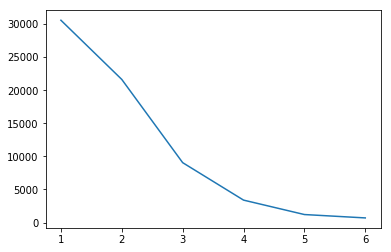

In [541]:
sample_submissions.attempts_range.value_counts().plot()

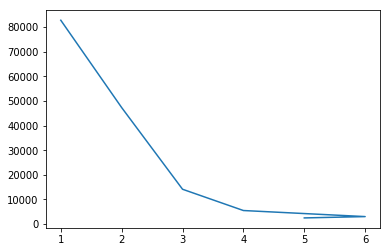

In [540]:
submissions.attempts_range.value_counts().plot()